(repeated-measures-notebook)=
# Misure ripetute

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
from scipy.constants import golden
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.3.0


In [3]:
%matplotlib inline
sns.set_theme(
    context="paper",
    style="darkgrid",
    palette="colorblind",
    rc={"figure.figsize": (5.0, 5.0 / golden)},
)
SEED = 42
rng = np.random.default_rng(SEED)

<!-- https://bayesiancomputationbook.com/markdown/chp_09.html -->

In questo tutorial analizzeremo statisticamente un campione di dati relativi ai tempi di reazione di un gruppo di partecipanti, tenendo conto della struttura nidificata dei dati con misurazioni ripetute. I dati con misurazioni ripetute sono comuni in psicologia cognitiva e neuroscienze e, sebbene spesso siano considerati un caso speciale nei test statistici e nelle scienze dei dati, la maggior parte dei dati provenienti dagli esperimenti psicologici includono misurazioni ripetute. Se non si è abituati a lavorare con questi dati, è facile commettere errori e trarre conclusioni errate.

Quando abbiamo dati nidificati, ci sono molte misurazioni per ogni individuo e quindi facendo la media su queste misurazioni si ottiene una stima più accurata della vera misura per ogni individuo. Tuttavia, se non consideriamo la struttura nidificata dei dati e facciamo la media dei dati tra tutti i partecipanti, perdiamo informazioni sulle differenze tra individui.

Per questo motivo, quando rappresentiamo graficamente i dati nidificati, è importante fare prima la media dei dati all'interno di ogni individuo per ogni condizione, e poi calcolare e visualizzare le misure della vera variabilità tra individui. In questo tutorial utilizzeremo pandas .groupby() per usare Seaborn in modo appropriato con dati nidificati. Il nostro obiettivo è esaminare gli effetti medi tra gli individui e la gamma di differenze tra di essi.

## Il flanker task

Iniziamo caricando un nuovo set di dati (`flanker.csv`). Si tratta di dati reali provenienti da un esperimento flanker. In questo esperimento, i partecipanti dovevano premere il tasto freccia sinistra o destra, per indicare se una freccia mostrata sullo schermo stava puntando a sinistra o a destra, rispettivamente. Tuttavia, la particolarità è che la freccia centrale è "contornata" da altre due frecce su ogni lato; queste possono essere orientate nella stessa direzione della freccia target (congruenti), o in direzione opposta (incongruenti). Ci aspettiamo che la condizione incongruente sia associata a tempi di reazione (RT) più lenti, perché le frecce di contorno creano una certa confusione visiva e competizione di risposta (interferenza cognitiva; questo processo non è diverso da quello alla base del famoso esperimento di Stroop). Per confermare questa ipotesi, vogliamo ottenere una stima del RT per ogni condizione, da un campione rappresentativo di partecipanti umani. Abbiamo bisogno di un certo numero di partecipanti perché sappiamo che c'è variabilità nella media del RT da persona a persona (variabilità tra soggetti). Qui abbiamo 27 partecipanti.

In [4]:
df = pd.read_csv("data/flanker.csv")
df.sample(10)

,participant,block,trial,flankers,rt
3094,s23,3,14,incongruent,0.505386
3007,s6,5,23,neutral,0.493036
1569,s1,5,13,neutral,0.392802
2780,s10,3,19,incongruent,0.569292
513,s22,2,2,neutral,0.469908
3445,s3,4,18,incongruent,0.553214
2600,s4,2,31,congruent,0.437766
109,s25,4,14,congruent,0.445393
2361,s26,5,15,neutral,0.581019
76,s25,3,13,neutral,0.385390



Per stimare la media dei tempi di reazione (RT) per ogni condizione per un individuo è necessario presentare molte prove per ogni condizione in ordine casuale. Ciò è dovuto alla variabilità tra le prove nella misura dei tempi di reazione (RT) umani (variabilità intra-soggetto). In questo studio, ogni partecipante ha completato 40 prove per ogni condizione. Pertanto, abbiamo misurazioni ripetute di RT per ogni partecipante, in ogni condizione sperimentale.

Questo esperimento incude anche una terza condizione, quella neutra. In questa condizione veniva presentata solo la freccia centrale, senza flanker. Questa condizione è stata inclusa per controllare il fatto che 5 frecce tutte rivolte nella stessa direzione potrebbero facilitare (accelerare) le risposte rispetto a una singola freccia, poiché potrebbero esserci effetti additivi e benefici dei flanker congruenti. Il confronto tra le condizioni congruenti e incongruenti rispetto alla condizione neutra ci consente di stimare il costo o il beneficio relativo dei flanker che sono incongruenti o congruenti con la direzione della freccia centrale. Per garantire che ci fossero tante prove neutre (con una sola freccia) quanto quelle con i flanker presenti (con cinque frecce), sono state incluse 80 prove neutre per partecipante.

I dati includono le prove di 27 partecipanti, con 160 prove per partecipante in totale. La struttura nidificata di questo dataset consiste quindi di prove (n = 160) nidificate nelle condizioni (n = 3) nidificate nei partecipanti (n = 27).

## Esaminare i dati senza considerare le misure ripetute

Inizieremo ottenendo alcune statistiche descrittive per il RT in ogni condizione. Usiamo il metodo `.groupby()` di pandas per raggruppare per condizione, e quindi selezioniamo la colonna `rt` (in secondi) per ulteriori elaborazioni mettendola tra parentesi quadre (che è il modo di pandas di selezionare le colonne). Infine concateniamo tutto ciò con il metodo `.describe()`:

In [5]:
df.groupby("flankers")["rt"].describe()


,count,mean,std,min,25%,50%,75%,max
flankers,,,,,,,,
congruent,1076.0,0.470568,0.098868,0.009837,0.401727,0.449814,0.521514,0.953989
incongruent,1064.0,0.515996,0.107581,0.061839,0.449544,0.504629,0.573016,0.965726
neutral,2149.0,0.498310,0.098934,0.031539,0.433521,0.485642,0.552863,0.980535


Si notino le frequenze assolute, la deviazione standard (`std`) così come i valori `min` e `max` per ogni condizione.

Diamo uno sguardo al box-plot dei valori in ogni condizione:

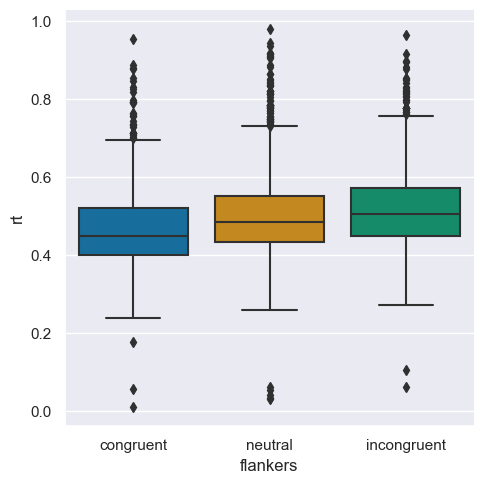

In [6]:
sns.catplot(kind="box", data=df, x="flankers", y="rt")
plt.show()


I dati mostrano la deviazione che ci si aspetta per i dati RT, dato che ci sono limiti prestazionali umani su quanto veloce una persona possa rispondere (RT brevi), ma il limite superiore dei RT è teoricamente illimitato. Nell'esperimento presente, i partecipanti avevano solo 1 secondo per rispondere, quindi tutti i RT sono inferiori a 1. Tuttavia, la distribuzione dei dati è asimmetrica positiva, come è normale per i dati relativi ai tempi di reazione. 

Un'altra cosa che possiamo vedere sulla distribuzione dei valori è che ci sono molti outlier nella coda positiva della distribuzione, ma pochi nella coda opposta. Anche questo è una conseguenza della natura dei dati RT. Tuttavia, notiamo che alcuni degli outlier nella coda inferiore della distribuzione sono sospetti: i RT umani in compiti molto semplici (come premere un pulsante ogni volta che si accende una luce) sono raramente inferiori a 200 ms, ma abbiamo alcuni valori RT al di sotto di tale soglia. Quindi i box plots suggeriscono che potremmo avere dei dati spuri forse provenienti da prove in cui qualcuno ha premuto un pulsante accidentalmente prima di elaborare effettivamente la direzione della freccia.

Infine, i box plots suggeriscono che i RT sono più lenti nella condizione incongruente e più veloci nella condizione congruente -- coerentemente con le nostre previsioni basate su studi precedenti sull'effetto flanker. I RT per la condizione neutra sono intermedi rispetto alle altre due condizioni. Ciò suggerisce che forse entrambi gli effetti di facilitazione nella condizione congruente e gli effetti di interferenza nella condizione incongruente sono presenti nei dati. Tuttavia, è difficile sapere quanto siano grandi o credibili tali differenze, poiché le distribuzioni si sovrappongono molto tra le tre condizioni.

Consideriamo un paio di altri modi di visualizzare i dati. Prima, utilizzeremo un grafico a violino  per vedere sia il KDE che il box plot.

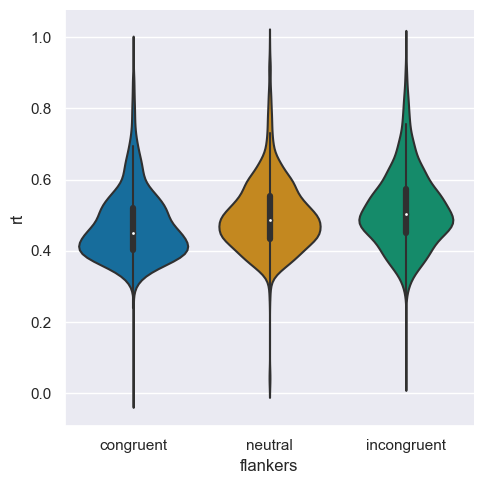

In [7]:
sns.catplot(kind="violin", data=df, x="flankers", y="rt")
plt.show()


La natura asimmetrica dei dati risulta ancora evidente, ma possiamo notare che non solo i valori mediani per le tre condizioni sono diversi, ma anche la maggioranza dei valori nelle distribuzioni di RT sembrano essere abbastanza differenti. Ciò significa che il 50% centrale di ogni distribuzione ha una sovrapposizione relativamente bassa, anche se le condizioni neutra e incongruente sono piuttosto simili.

Successivamente, analizziamo il grafico a punti ("strip plot") dei dati, che rappresenta ogni singolo punto dati separatamente:

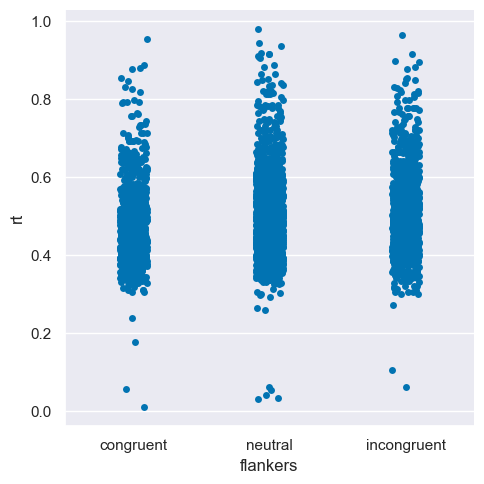

In [8]:
sns.catplot(kind="strip", data=df, x="flankers", y="rt")
plt.show()


Questo grafico ci mostra qualcosa di interessante che non era evidente nei grafici precedenti: i punti dei dati molto veloci si discostano molto dagli altri dati, ovvero sono degli outlier persino rispetto agli outlier all'estremo opposto, ovvero rispetto ai RT molto lenti. Ci sono pochi RT "veloci" e sono generalmente molto distanti dal resto della distribuzione dei tempi di reazione. Al contrario, i RT più lenti sono più numerosi e sembrano formare un insieme piuttosto continuo di valori, seppur più rari rispetto ai punti più vicini ai centri delle distribuzioni. Ciò suggerisce che i RT più lenti potrebbero essere piuttosto credibili come dati reali: nella maggior parte dei casi le persone danno risposte più veloci, ma a volte sono un po' più lente. Al contrario, il grafico ci dà maggior fiducia nel fatto che i tempi di reazione molto veloci dovrebbero essere eliminati dall'analisi, perché non sono solo delle piccole variazioni rispetto alle altre risposte veloci, ma qualcosa di qualitativamente diverso.

## Pulizia dei dati

Una fase cruciale nell'analisi dei dati è la pulizia dei dati, che consiste nell'individuare e rimuovere i punti dati che potrebbero essere errati a causa di errori nella raccolta dei dati o altri fattori che potrebbero compromettere le conclusioni che si possono trarre. Tale operazione non va confusa con la manipolazione dei dati, che implica una modifica volontaria per ottenere i risultati desiderati. La pulizia dei dati richiede l'utilizzo di specifici metodi progettati per individuare e rimuovere i punti dati oggettivamente anomali, cioè quelli che si possono rimuovere con ragionevole certezza. È fondamentale documentare le operazioni di pulizia dei dati in modo trasparente e riproducibile, inclusi i passaggi nel codice utilizzato per l'analisi.

### Metodo di Tukey

John Tukey, un importante statistico, ha definito gli outlier come punti dati che si trovano al di fuori di 1.5 volte l'IQR in un set di dati. L'IQR è l'intervallo interquartile che cattura il 50% dei dati e viene rappresentato come il rettangolo centrale in un box plot, mentre i valori oltre 1.5 IQR sono rappresentati come "whiskers". Questa definizione di outlier è comunemente usata dai ricercatori e di solito rappresenta circa l'1% dei dati se questi sono distribuiti approssimativamente in modo normale.

Tuttavia, questa definizione potrebbe non essere appropriata per tutti i tipi di dati. Ad esempio, i dati relativi ai tempi di reazione spesso non seguono una distribuzione normale e possono essere rappresentati da distribuzioni asimmetriche come la log-normale o l'ex-gaussiana. Nel caso presente, inoltre, abbiamo visto che ci sono dei valori "impossibili" o non plausibili, come valori inferiori a 200 ms. Tali valori rappresentano sicuramente degli outlier e devono essere rimossi per evitare distorsioni nei risultati.

Nella pulizia dei dati, potremmo sostituire gli outlier con valori non informativi come la media della distribuzione, ma in caso di distribuzioni asimmetriche, è meglio utilizzare la mediana. Inoltre, se eliminare gli outlier potrebbe rendere i dati sbilanciati, è meglio sostituirli con la mediana della condizione a cui appartengono, anziché la mediana di tutti i dati.

Per fare questo iniziamo a trovare la mediana in ciascuna condizione.

In [9]:
df.groupby('flankers')['rt'].describe()

,count,mean,std,min,25%,50%,75%,max
flankers,,,,,,,,
congruent,1076.0,0.470568,0.098868,0.009837,0.401727,0.449814,0.521514,0.953989
incongruent,1064.0,0.515996,0.107581,0.061839,0.449544,0.504629,0.573016,0.965726
neutral,2149.0,0.498310,0.098934,0.031539,0.433521,0.485642,0.552863,0.980535


Aggiungiamo ora una colonna al DataFrame che identifica gli outlier.

In [10]:
df['outlier'] = df.loc[:, 'rt'] < 0.2
df.head()

,participant,block,trial,flankers,rt,outlier
0,s25,1,1,congruent,0.652072,False
1,s25,1,2,neutral,0.644872,False
2,s25,1,3,congruent,0.445182,False
3,s25,1,4,neutral,0.525200,False
4,s25,1,5,congruent,0.533328,False


Troviamo il numero di outlier nel DataFrame.

In [11]:
df["outlier"].sum()

10

Sostituiamo ora gli outlier in ciascuna condizione con la mediana di quella condizione. L'istruzione `np.where()` prende tre argomenti. Il primo è una condizione logica. Se la condizione logica specificata viene soddisfatta, allora viene eseguita l'operazione specificata dal secondo argomento. Se invece la condizione logica è falsa, viene eseguita l'operazione specificata dal terzo argomento.

Nel caso presente, l'operazione che viene specificata è l'attribuzione di un valore ad un nuovo vettore che aggiungiamo al DataFrame e chiamiamo `rt_clean`. Eseguiamo questa procedura tre volte, una volta per ciascuna condizione. Si noti che, dopo la prima volta che abbiamo applicato il metodo `np.where()`, abbiamo creato la colonna di dati `rt_clean`. Nei successivi due passi dobbiamo usare `rt_clean` e non `rt`.

Ci sono modi più eleganti per ottenere questo risultato, ma questa procedura è la più intuitiva.

In [12]:
df["rt_clean"] = np.where(
    (df["flankers"] == "congruent") & (df["outlier"] == True), 0.449814, df["rt"]
)

df["rt_clean"] = np.where(
    (df["flankers"] == "incongruent") & (df["outlier"] == True), 0.504629, df["rt_clean"]
)

df["rt_clean"] = np.where(
    (df["flankers"] == "neutral") & (df["outlier"] == True), 0.485642, df["rt_clean"]
)

In [13]:
df.groupby("flankers")[["rt", "rt_clean"]].describe()

rt                                                     
              count      mean       std       min       25%       50%   
flankers                                                                
congruent    1076.0  0.470568  0.098868  0.009837  0.401727  0.449814  \
incongruent  1064.0  0.515996  0.107581  0.061839  0.449544  0.504629   
neutral      2149.0  0.498310  0.098934  0.031539  0.433521  0.485642   

                                rt_clean                                 
                  75%       max    count      mean       std       min   
flankers                                                                 
congruent    0.521514  0.953989   1076.0  0.471596  0.096631  0.238780  \
incongruent  0.573016  0.965726   1064.0  0.516787  0.105929  0.273058   
neutral      0.552863  0.980535   2149.0  0.499336  0.096474  0.258747   

                                                     
                  25%       50%       75%       max  
flankers                                             
congruent    0.402036  0.449874  0.521514  0.953989  
incongruent  0.449682  0.504728  0.573016  0.965726  
neutral      0.433634  0.485642  0.552863  0.980535

Nel caso di dati annidati, come i presenti, è però più opportuno sostituire ai dati mancanti la mediana calcolata non solo per condizione, ma anche per soggetto. 

In [14]:
df["rt_clean"] = df["rt"].where(
    df["outlier"] == False,
    df.groupby(["participant", "flankers"])["rt"].transform("median"),
)


La funzione `where` sostituisce i valori dell'array con quelli forniti quando la condizione specificata è True, altrimenti mantiene i valori originali. Nel nostro caso, utilizziamo la colonna `outlier` come condizione, in modo che i valori di `rt` siano sostituiti solo quando `outlier` è `True`.

Quando `outlier` è `True`, utilizziamo la funzione `groupby` per calcolare la mediana di `rt` per ciascuna combinazione di partecipante e condizione flanker. Infine, utilizziamo la funzione `transform` per applicare la mediana ai gruppi di dati corrispondenti all'interno del dataframe originale.

Nel caso presente, considerato l'esiguo numero di dati mancanti, le due procedure producono risultati molto simili.

In [15]:
df.groupby("flankers")[["rt", "rt_clean"]].describe()


rt                                                     
              count      mean       std       min       25%       50%   
flankers                                                                
congruent    1076.0  0.470568  0.098868  0.009837  0.401727  0.449814  \
incongruent  1064.0  0.515996  0.107581  0.061839  0.449544  0.504629   
neutral      2149.0  0.498310  0.098934  0.031539  0.433521  0.485642   

                                rt_clean                                 
                  75%       max    count      mean       std       min   
flankers                                                                 
congruent    0.521514  0.953989   1076.0  0.471547  0.096649  0.238780  \
incongruent  0.573016  0.965726   1064.0  0.516782  0.105929  0.273058   
neutral      0.552863  0.980535   2149.0  0.499316  0.096478  0.258747   

                                                     
                  25%       50%       75%       max  
flankers                                             
congruent    0.402036  0.449814  0.521514  0.953989  
incongruent  0.449682  0.504629  0.573016  0.965726  
neutral      0.433634  0.485642  0.552863  0.980535

## Medie e intervalli di confidenza

Una rappresentazione molto comune dei dati è quella di riportare la media e l'intervallo di confidenza al 95%. Nel caso presente questa rappresentazione è problematica, in quanto la media è una misura appropriata di tendenza centrale solo quando la distribuzione dei dati è simmetrica. 

Al di là di questo problema consideriamo il concetto di intervallo di confidenza frequentista. Anticipiamo qui una discussione che verrà approfondita nei capitoli successivi. Tuttavia, si noti che questo argomento era già stato affrontato nei capitoli sulla teoria della probabilità. In quella discussione precedente abbiamo considerato la variabile casuale che corrisponde alla media di $n$ osservazioni iid, ciascuna delle quali distribuita con media $\mu$ e varianza $\sigma^2$. Abbiamo trovato che la varianza di una tale variabile casuale è

$$
\mathbb{V}(\bar{x}) = \frac{\sigma^2}{n}.
$$

La radice quadrata di tale quantità di chiama *errore standard* della media campionaria. Ci dice di quanto ci aspettiamo che vari, in media, la media campionaria da campione a campione. È una misura della variabilità della media campionaria nell'universo dei campioni.

È dunque comune rappresentare la media di un campione con l'informazione aggiuntiva dell'intervallo di confidenza, per fornire una misura di quanto ci aspettiamo che la media del campione vari tra diversi campioni. 

Si definisce *intervallo di confidenza* al livello di fiduca del 95% come

$$
\bar{x} \pm 1.96 \frac{s}{\sqrt{n}},
$$

dove $s$ è la stima della varianza della popolazione calcolata sulla base dei dati del campione.

Nel nostro caso, abbiamo tre condizioni (congruent, incongruent, neutral), quindi possiamo calcolare la media e l'intervallo di confidenza in ciascuna condizione. Ciò ci fornisce una stima del valore di tendenza centrale in ciascuna condizione e dell'intertezza della stima.

Si noti però che la misura di incertezza, fornita dall'intervallo di fiducia, ha un significato completamente diverso dalla misura di incertezza fornita dalla stima bayesiana. Questo argomento verrà approfondito nei capitoli successivi. Per ora ci limitiamo ad affrontare il problema di calcolare l'intervallo di confidenza (frequentista) al 95%.

Questo può essere fatto con facilità mediante l'istruzione seguente.

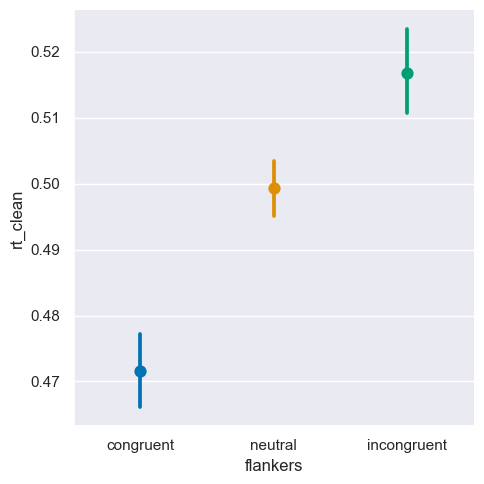

In [16]:
sns.catplot(kind="point", join=False, data=df, x="flankers", y="rt_clean", hue="flankers")
plt.show()


Il grafico mostra la media per ogni condizione, insieme agli intervalli di confidenza al 95% (CI) come misura di varianza. Gli intervalli di confidenza sono molto più stretti dei box plot esaminati in precedenza, perché sono destinati a rappresentare la nostra fiducia nella stima della media, piuttosto che mostrare la distribuzione complessiva dei valori. In generale, i ricercatori tendono ad interpretare le condizioni con intervalli di confidenza al 95% che non si sovrappongono come "statisticamente diverse" tra loro, ma questa interpretazione, nel caso degli intervalli frequentisti, non è sempre appropriata.

Nel caso presente, inoltre, gli intervalli calcolati così come è mostrato nella figura sono certamente sbagliati. Questo grafico è ingannevole perché non abbiamo distinto la varianza all'interno del partecipante da quella tra i partecipanti, ovvero non abbiamo tenunto conto in nessun modo del fatto che i dati hanno una struttura nidificata.

## Esaminare le differenze individuali

Adesso, utilizziamo la tecnica *split-apply-combine* per calcolare la media dei tempi di reazione (RT) per ciascun partecipante (e per ciascuna condizione all'interno dei partecipanti) *prima* di calcolare le statistiche descrittive a livello di gruppo. Possiamo farlo in una sola riga di codice concatenando i seguenti passaggi:

- raggruppare i dati per partecipante e condizione (split). Si noti che l'argomento di `.groupby()` è una lista contenente le due colonne per le quali vogliamo raggruppare i dati;
- calcolare la media (o la mediana) per ciascuna condizione all'interno di ciascun partecipante (apply).

In [17]:
df.groupby(["participant", "flankers"])["rt_clean"].describe()


count      mean       std       min       25%   
participant flankers                                                     
s1          congruent     39.0  0.455259  0.062264  0.345359  0.405289  \
            incongruent   40.0  0.471838  0.076799  0.373203  0.422353   
            neutral       80.0  0.476104  0.071508  0.357297  0.429230   
s10         congruent     40.0  0.471231  0.078493  0.329720  0.403671   
            incongruent   40.0  0.499031  0.068776  0.301630  0.467616   
...                        ...       ...       ...       ...       ...   
s8          incongruent   40.0  0.515772  0.093129  0.376593  0.472400   
            neutral       80.0  0.482396  0.076766  0.292967  0.435612   
s9          congruent     40.0  0.431829  0.074206  0.316626  0.382794   
            incongruent   39.0  0.437926  0.083530  0.301302  0.381454   
            neutral       80.0  0.432177  0.061369  0.304624  0.389656   

                              50%       75%       max  
participant flankers                                   
s1          congruent    0.445225  0.495277  0.597253  
            incongruent  0.463064  0.506307  0.777096  
            neutral      0.467111  0.514231  0.783683  
s10         congruent    0.463479  0.521448  0.689298  
            incongruent  0.499406  0.553274  0.637271  
...                           ...       ...       ...  
s8          incongruent  0.503623  0.541888  0.881690  
            neutral      0.480235  0.525675  0.644778  
s9          congruent    0.413070  0.468954  0.646603  
            incongruent  0.421338  0.487607  0.705617  
            neutral      0.431551  0.462674  0.609026  

[81 rows x 8 columns]

In questo modo otteniamo moltissimi valori! Infatti, sono così tanti che pandas non ci mostra tutte le righe. Da quanto si può vedere, possiamo notare che ci sono certamente differenze individuali nelle medie di RT e nella varianza (misurata dalla deviazione standard), ma è difficile avere una vera percezione di quanto sia grande la variabilità inter-individuale.

## Visualizzare le differenze individuali 

Con Seaborn è possibile visualizzare i dati in base ai partecipanti. Una delle opzioni disponibili è quella di generare un box plot, come fatto in precedenza, ma invece di posizionare la condizione del flanker sull'asse x, si può rappresentare ciascun partecipante sull'ascissa utilizzando l'argomento `hue` per colorare in modo differente le diverse condizioni del flanker. Poiché il numero di partecipanti può essere elevato, si può specificare l'argomento `aspect=3` per indicare a Seaborn di renderizzare il grafico con una larghezza tripla rispetto all'altezza.

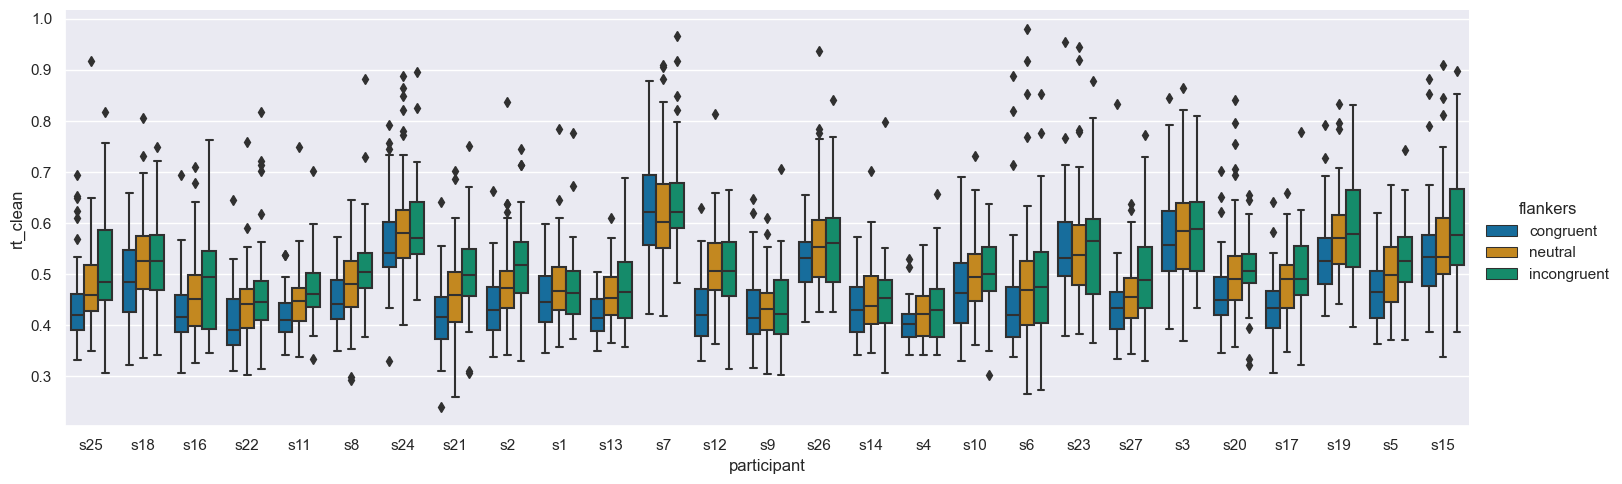

In [18]:
sns.catplot(kind="box", data=df, x="participant", y="rt_clean", hue="flankers", aspect=3)
plt.show()


Si può visualizzare un gran numero di box plot utilizzando gli argomenti `col` e `col_wrap` di Seaborn. L'argomento `col=` traccerà la variabile specificata in colonne separate - nel nostro caso, i partecipanti (anziché come diverse posizioni sull'asse x, come mostrato sopra). Quando il numero di categorie passate a `col` è grande, come nel nostro caso con 27 partecipanti, è necessario aggiungere l'argomento `col_wrap` per indicare a Seaborn quanti grafici disporre su una riga prima di passare a una nuova riga.

Inoltre, per rendere più facile la lettura dei caratteri quando si hanno tanti grafici, utilizzeremo il contesto 'talk' di Seaborn, ma lo impostiamo nuovamente su 'paper' dopo aver mostrato il grafico per evitare di influenzare i grafici successivi.

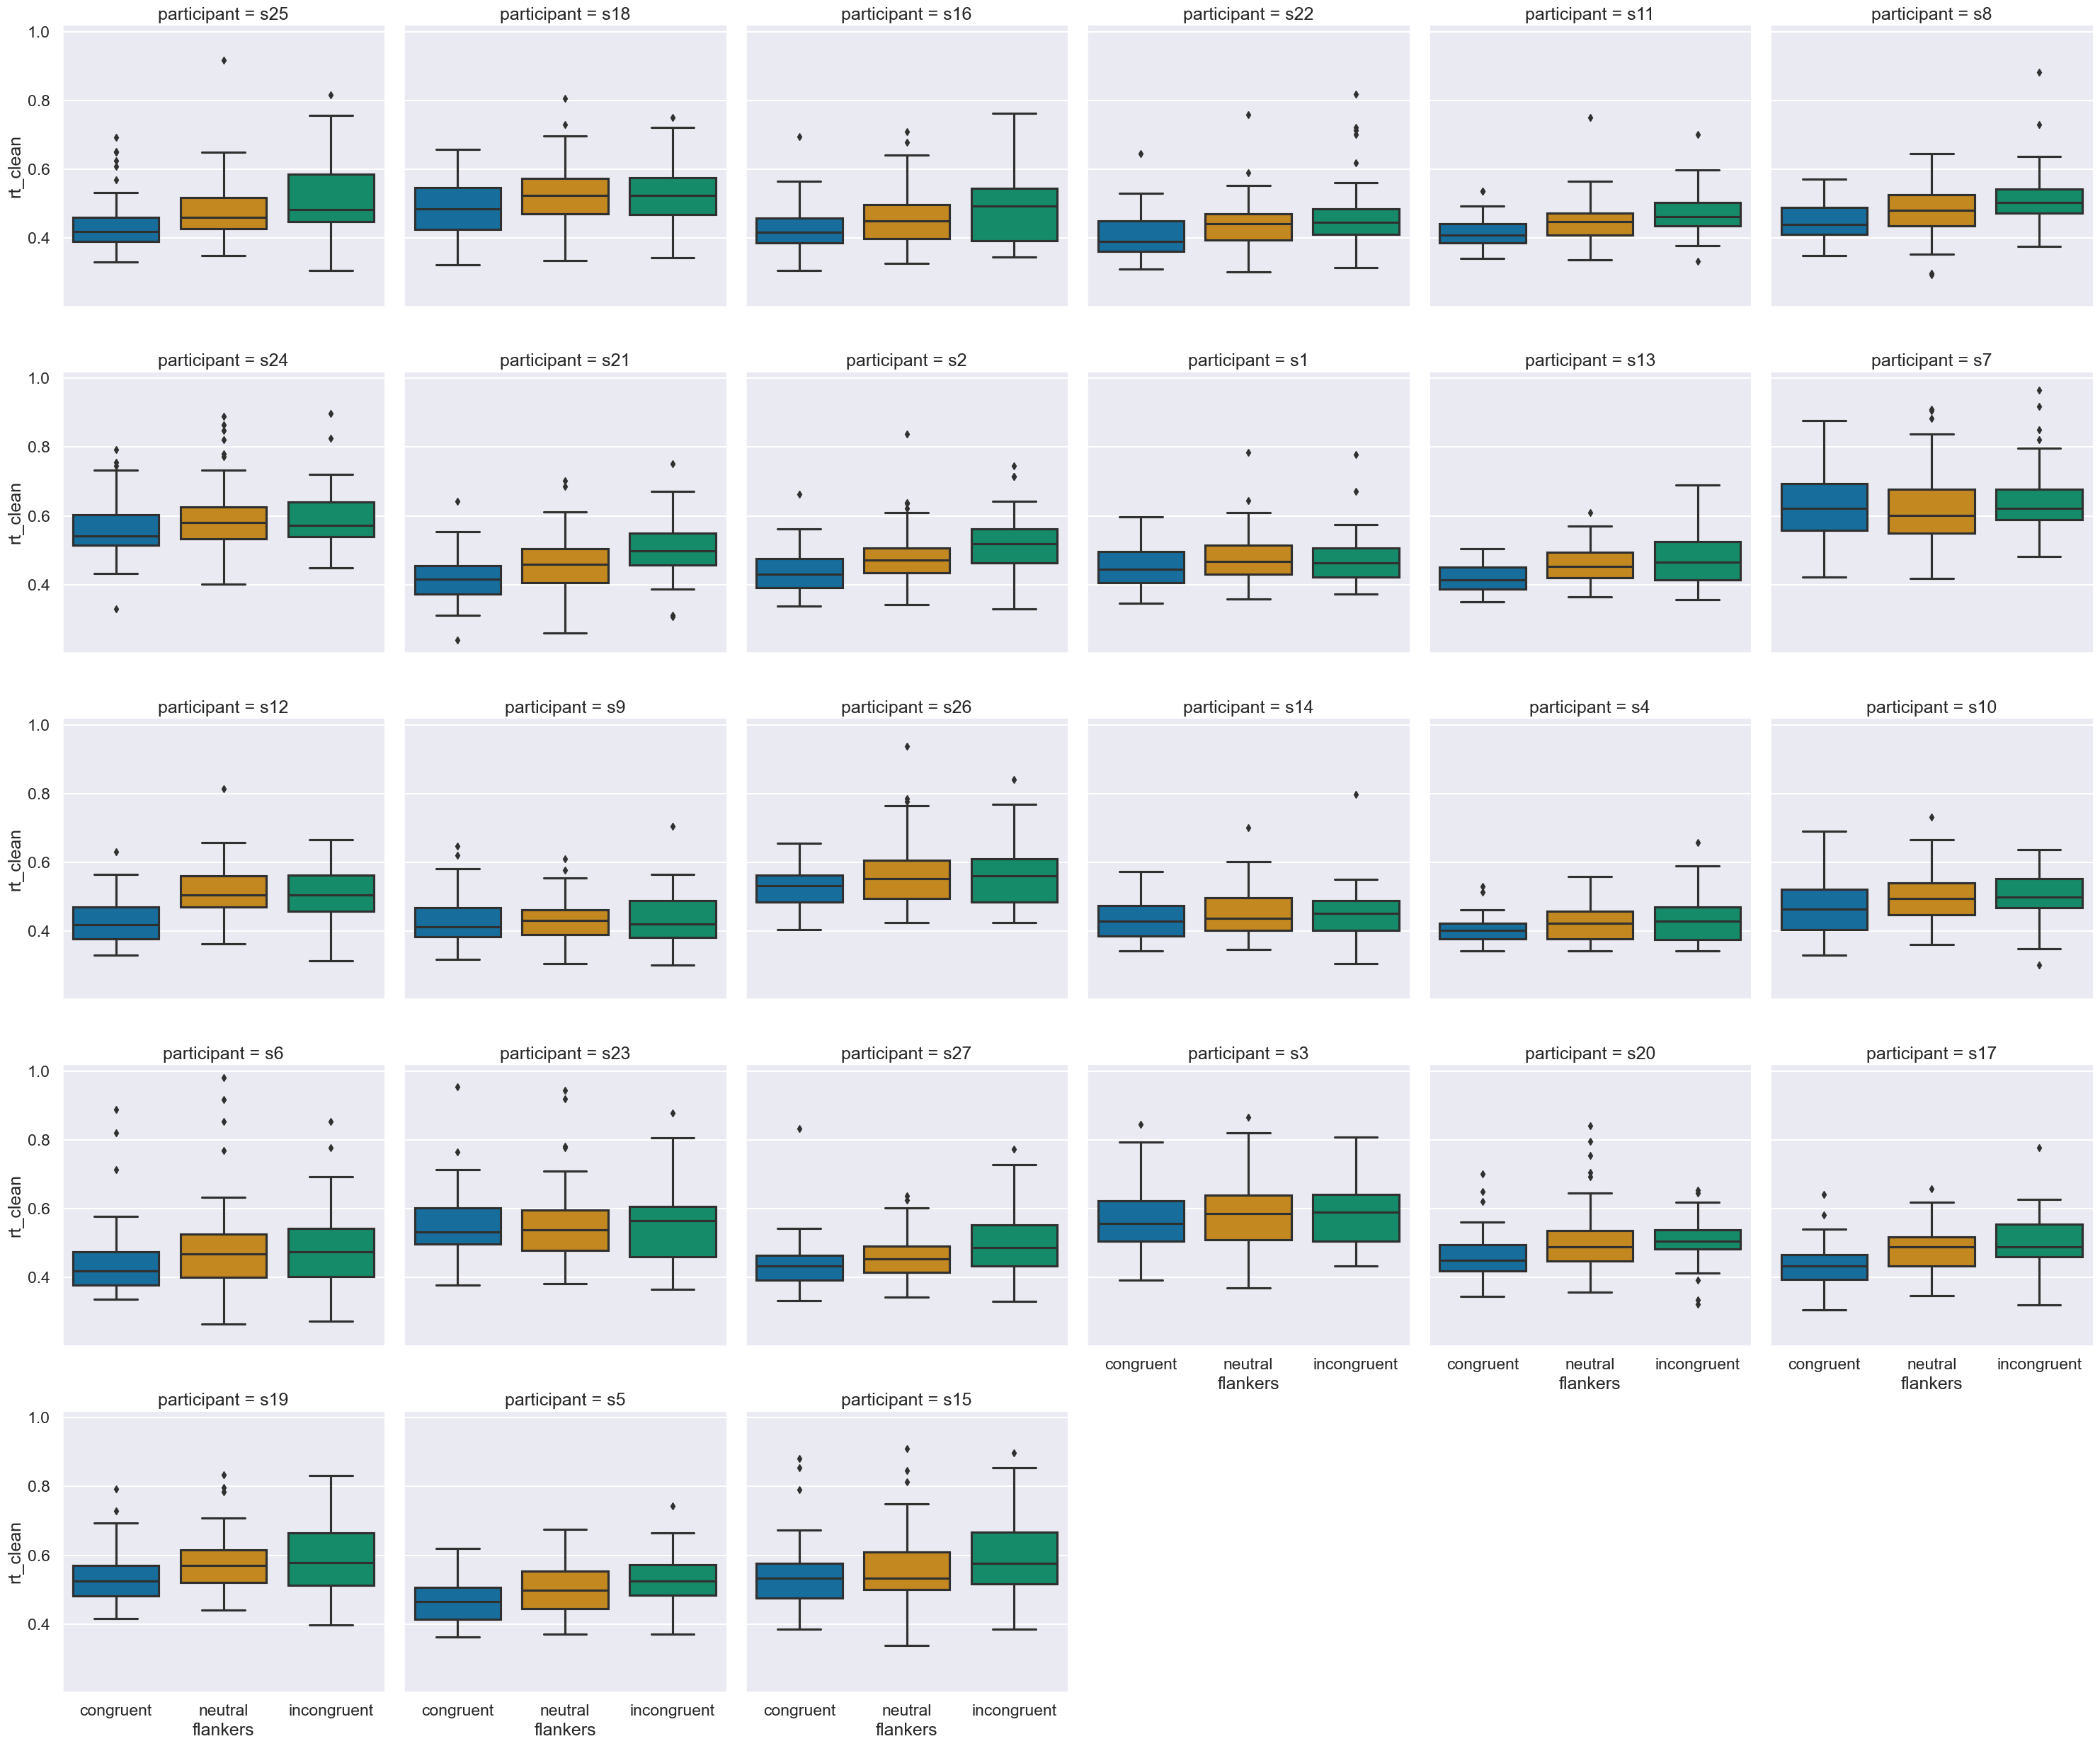

In [19]:
sns.set_context("talk")
sns.catplot(
    kind="box",
    data=df,
    x="flankers",
    y="rt_clean",
    col="participant",
    col_wrap=6,
)
plt.show()
sns.set_context("paper")


Il grafico mostra che effettivamente ci sono differenze tra i partecipanti sia per la mediana dei tempi di reazione che per la varianza (questo si nota dalla lunghezza dei wiskers e dal numero dei valori anomali). Tuttavia, è incoraggiante notare che ogni partecipante sembra mostrare l'effetto atteso, ovvero tempi di reazione più lunghi per i flanker incongruenti rispetto a quelli congruenti. 

## Aggregare i dati per partecipante

Poiché ci sono molti punti dati e variazioni sia nella media che nell'intervallo dei valori tra i partecipanti, è necessario aggregare i dati all'interno di ciascun partecipante e condizione prima di calcolare le statistiche descrittive o visualizzarli. In questo modo, si garantisce che la varianza esaminata sia quella tra i soggetti e non confusa con quella all'interno dei soggetti. Ciò è particolarmente importante nella generazione di grafici che mostrano gli intervalli di confidenza (CI), come i grafici a punti e a barre, e rappresenta il modo corretto per rappresentare le misure di tendenza centrale e variabilità nel caso di dati nidificati.

Seaborn ha una funzione che consente di effettuare con facilità quando si generano i grafici, utilizzando l'argomento `units=` e passando il nome della variabile di raggruppamento per le misure ripetute (in questo caso, `participant`):

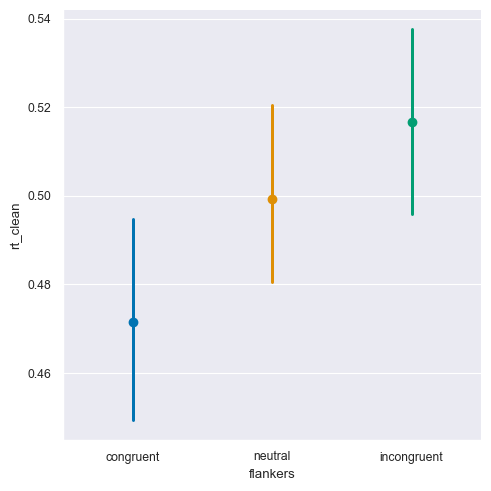

In [20]:
sns.catplot(
    kind="point",
    join=False,
    data=df,
    units="participant",
    x="flankers",
    y="rt_clean",
    hue="flankers",
)
plt.show()


In questo capitolo è stata presentata una figura che mostra i tempi di reazione in tre diverse condizioni sperimentali: neutra, flanker congruenti e flanker incongruenti. Rispetto al grafico a punti e barre con i CI al 95% che era stato generato in precedenza per i dati aggregati, il grafico attuale mostra CI molto più ampi. Questo è dovuto al fatto che i CI sono calcolati dividendo la deviazione standard per la radice quadrata del numero di punti dati utilizzati per calcolare la media e la deviazione standard

$$
\bar{x} \pm 1.96 \frac{s}{\sqrt{n}}.
$$

Nel caso dei dati non aggregati, il numero di punti dati era di circa 1000-2000 per ogni condizione, mentre per i dati aggregati il numero era di soli 27. Pertanto, i CI sono molto più ampi nei dati aggregati.

È importante notare che le conclusioni che trarremmo dal grafico sarebbero state molto diverse se avessimo usato il primo grafico a punti generato dai dati non aggregati. In quel caso, i tempi di reazione sembravano molto diversi tra le tre condizioni, con CI piccoli e non sovrapposti, suggerendo una grande differenza tra di esse. Tuttavia, quando i dati sono aggregati correttamente, i CI per la condizione neutra si sovrappongono molto con entrambe le condizioni flanker, il che suggerisce una minore differenza tra le condizioni. 

In questo contesto, l'interpretazione dei dati correnti è meno importante rispetto alla comprensione dell'importanza di riconoscere e trattare correttamente i dati a misure ripetute. È essenziale comprendere gli effetti delle misure ripetute e dell'annidamento sulla stima della varianza e delle differenze tra le misure di varianza nei dati e le stime della nostra fiducia nella precisione della media. 

## Aggregazione usando Split-Apply-Combine

Ora creeremo un DataFrame aggregato che può essere utilizzato per generare tabelle di statistiche descrittive e, infine, eseguire analisi statistiche. Per fare ciò, useremo due operazioni di split-apply-combine in sequenza. In un unico comando concatenato, divideremo i dati per partecipante e condizione, selezioneremo la colonna "rt" e calcoleremo una misura di tendenza centrale dell'RT per ogni partecipante/condizione.


In [21]:
df.groupby(["participant", "flankers"])["rt_clean"].mean().groupby("flankers").describe()


,count,mean,std,min,25%,50%,75%,max
flankers,,,,,,,,
congruent,27.0,0.471858,0.059504,0.401993,0.432788,0.450102,0.508700,0.628185
incongruent,27.0,0.517491,0.052757,0.428867,0.484333,0.507033,0.542447,0.650769
neutral,27.0,0.499697,0.052931,0.422821,0.458468,0.482094,0.537580,0.619004


Si confrontano le frequenze assolute, la media, la mediana, la deviazione standard, il valore minimo e massimo qui riportati con quelli trovati sopra, che riprodurremo qui per facilitare il confronto:

In [22]:
df.groupby("flankers")["rt_clean"].describe()


,count,mean,std,min,25%,50%,75%,max
flankers,,,,,,,,
congruent,1076.0,0.471547,0.096649,0.238780,0.402036,0.449814,0.521514,0.953989
incongruent,1064.0,0.516782,0.105929,0.273058,0.449682,0.504629,0.573016,0.965726
neutral,2149.0,0.499316,0.096478,0.258747,0.433634,0.485642,0.552863,0.980535


Nella tabella aggregata si può notare che il numero di osservazioni si riduce rispetto al totale delle prove eseguite da tutti i partecipanti (~4200) a soli 27 per ogni condizione (corrispondenti al numero di partecipanti). La media dei tempi di reazione non cambia, come ci si aspetta dato che la media è un'operazione lineare, quindi la media di tutte le prove è equivalente a fare la media prima all'interno dei partecipanti e poi tra le prove.

Tuttavia, la varietà di valori presenti nei dati originari diminuisce quando consideriamo i valori minimi e massimi. Ciò è una conseguenza normale della media, poiché i valori estremi trovati in un insieme di dati individuali saranno ridotti quando si effettua la media su alcune variabili di raggruppamento (come il partecipante).

Anche la varianza (espressa dalla deviazione standard, std) si riduce, poiché ora si calcola la varianza tra le medie dei tempi di reazione per ogni partecipante in ogni condizione, i quali hanno un intervallo più piccolo rispetto ai dati grezzi.

## Grafici per i dati aggregati

Adesso procediamo con la creazione di un grafico utilizzando i dati aggregati per ogni partecipante. Per fare ciò, salviamo i dati aggregati in un nuovo DataFrame chiamato `df_avg`. Quindi, convertiamo le colonne degli indici in colonne regolari del DataFrame utilizzando il metodo `.reset_index()`.

In [23]:
df_avg = pd.DataFrame(
    df.groupby(["participant", "flankers"])["rt_clean"].mean()
).reset_index()
print(df_avg)

   participant     flankers  rt_clean
0           s1    congruent  0.455259
1           s1  incongruent  0.471838
2           s1      neutral  0.476104
3          s10    congruent  0.471231
4          s10  incongruent  0.499031
..         ...          ...       ...
76          s8  incongruent  0.515772
77          s8      neutral  0.482396
78          s9    congruent  0.431829
79          s9  incongruent  0.437926
80          s9      neutral  0.432177

[81 rows x 3 columns]


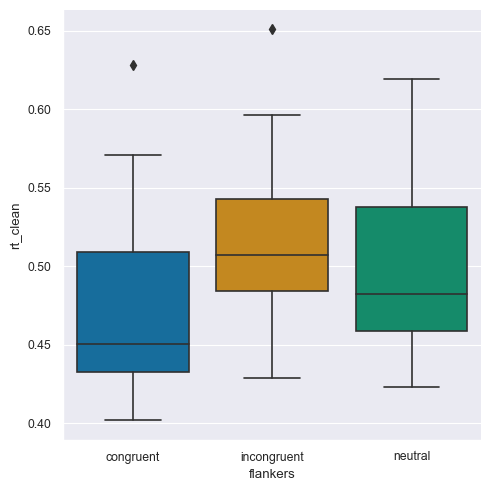

In [24]:
sns.catplot(kind="box", data=df_avg, x="flankers", y="rt_clean")
plt.show()


Si noti che l'ordine delle condizioni sull'asse x è stato invertito: in precedenza l'ordine era congruente - neutrale - incongruente, ma ora neutrale appare per ultimo. Ciò è dovuto al metodo `.reset_index()`, che ha riordinato le condizioni in ordine alfabetico. Seaborn ha un modo semplice per specificare l'ordine dei valori su un asse che riporta le modalità di una variabile categoriale: è sufficiente usare l'argomento `order=` e fornire una lista nell'ordine in cui si desidera che le modalità compaiano nel grafico.

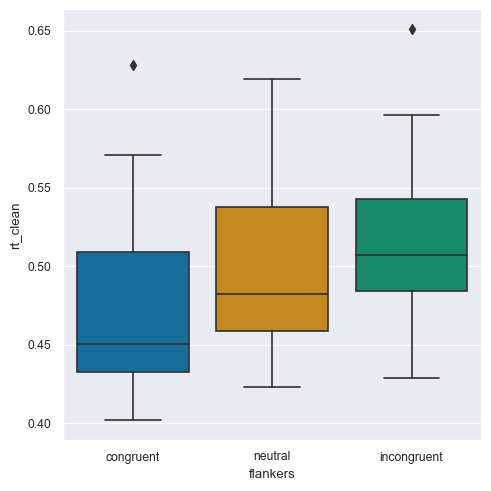

In [25]:
sns.catplot(
    kind="box",
    data=df_avg,
    x="flankers",
    y="rt_clean",
    order=["congruent", "neutral", "incongruent"],
)
plt.show()


Se si confronta questo box plot con quello basato sui dati non aggeregati che abbiamo generato in precedenza, si noterà che l'intervallo coperto dai boxplot è più piccolo. Questo è coerente con la riduzione dell'intervallo dei dati che abbiamo osservato nelle tabelle di statistica descrittiva. 

La presentazione dei dati individuali per condizione ora è più comprensibile, dato che abbiamo solo 27 punti per condizione.

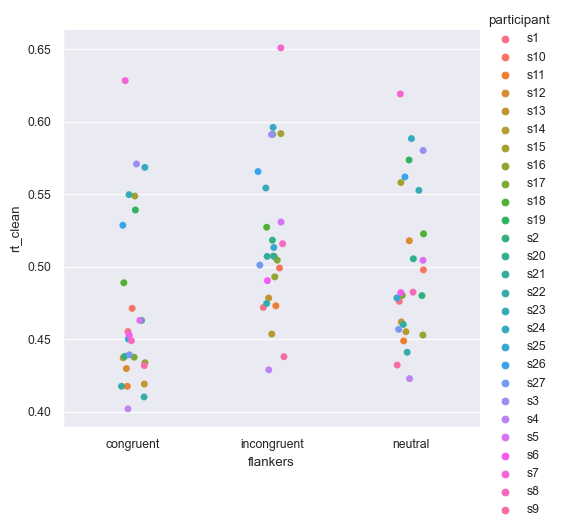

In [26]:
sns.catplot(kind="strip", data=df_avg, x="flankers", y="rt_clean", hue="participant")
plt.show()


Nel grafico precedente è un po' difficile vedere come cambiano i tempi di reazione individuali tra le due condizioni sperimentali. Per facilitare la visualizzazione, utilizziamo un grafico a punti, che per impostazione predefinita disegna linee per unire i dati di ogni singolo individuo.

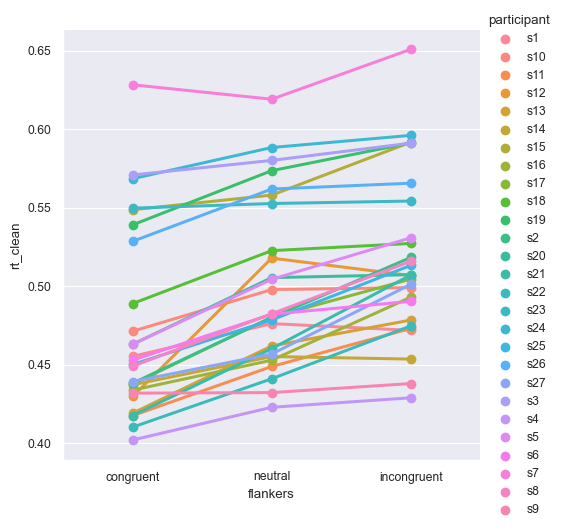

<Figure size 500x309.017 with 0 Axes>

In [27]:
sns.catplot(
    kind="point",
    data=df_avg,
    x="flankers",
    y="rt_clean",
    hue="participant",
    order=["congruent", "neutral", "incongruent"],
)
plt.show()
plt.tight_layout()


## Inferenza

Procediamo ora con l'inferenza bayesiana. In base a quanto esposto in precedenza, il metodo più semplice è quello di aggregare i dati in modo da ottenere una singola stima dell'effetto di interesse per ciascun soggetto. Dal momento che i dati sono asimmetrici, utilizzeremo la mediana come misura di tendenza centrale. A tal fine, creiamo il DataFrame che utilizzeremo per l'analisi statistica.

In [29]:
grouped_data = df.groupby(['participant', 'flankers'])['rt_clean'].median()
# Convert the resulting pandas Series to a DataFrame
result_df = grouped_data.reset_index()
result_df

,participant,flankers,rt_clean
0,s1,congruent,0.445225
1,s1,incongruent,0.463064
2,s1,neutral,0.467111
3,s10,congruent,0.463479
4,s10,incongruent,0.499406
...,...,...,...
76,s8,incongruent,0.503623
77,s8,neutral,0.480235
78,s9,congruent,0.413070
79,s9,incongruent,0.421338


Si ricordi che i dati hanno una struttura nidificata a causa delle condizioni entro i soggetti, anche se aggreghiamo i dati e consideriamo solo tre valori per ciascun soggetto (uno per ciascuna condizione). Pertanto, l'analisi statistica inferenziale per dati raggruppati è complessa. Tuttavia, se consideriamo solo due condizioni, possiamo semplificare il problema calcolando la differenza tra di esse e ottenere così un solo dato per soggetto. In questo modo, la struttura nidificata scompare e possiamo procedere con l'analisi statistica come descritto in precedenza.

Per semplificare l'analisi, ci concentreremo sulla differenza tra le condizioni congruente e incongruente, ignorando la condizione neutra, per verificare se questa differenza sia statisticamente "credibile".

Iniziamo a filtrare le righe del DataFrame in modo da eliminare tutte le righe nelle quali la variable `flanker` assume la modalità `neutral`.

In [32]:
# filter rows 
result_df = result_df[result_df['flankers'] != 'neutral']
result_df.head()

,participant,flankers,rt_clean
0,s1,congruent,0.445225
1,s1,incongruent,0.463064
3,s10,congruent,0.463479
4,s10,incongruent,0.499406
6,s11,congruent,0.409306


Il secondo passo è quello di calcolare la differenza tra le condizioni incongruente e congruente, per ciascun soggetto. Un modo semplice per ottenere questo risultato è quello di ottenere un DataFrame nel quale sono presenti due colonne diverse che includono i RT per la condizione congruente e incongruente.

In [33]:
df_wide = result_df.pivot(index='participant', columns='flankers', values='rt_clean')
df_wide.head()


flankers,congruent,incongruent
participant,,
s1,0.445225,0.463064
s10,0.463479,0.499406
s11,0.409306,0.461581
s12,0.419370,0.506001
s13,0.412955,0.464735


Troviamo ora la differenza nei RT tra la condizione incongruente (più lenta) e quella congruente (più veloce). Si noti che tale differenza è positiva per tutti i soggetti, il che significa che l'effetto di interferenza dei flankers ha rallentato la prestazione per tutti i soggetti.

In [34]:
df_wide["rt_diff"] = df_wide["incongruent"] - df_wide["congruent"]
df_wide.head()

flankers,congruent,incongruent,rt_diff
participant,,,
s1,0.445225,0.463064,0.017839
s10,0.463479,0.499406,0.035927
s11,0.409306,0.461581,0.052275
s12,0.419370,0.506001,0.086631
s13,0.412955,0.464735,0.051780


Esaminiamo l'effetto flanker con un istogramma.

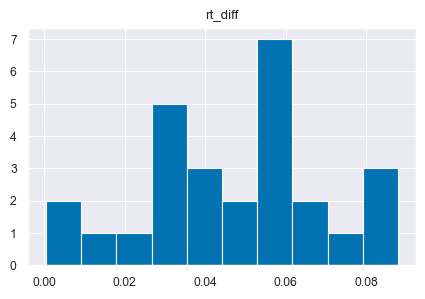

In [35]:
_ = df_wide.hist("rt_diff")

Eseguiamo ora l'inferenza bayesiana assumendo che i dati siano distribuiti normalmente. Per la media usiamo una distribuzione a priori normale centrata sullo zero con una deviazione standard sufficientemente grande da includere tutti i dati osservati. Per la deviazione standard usiamo una distribuzione normale troncata centrata sullo zero e sufficientemente ampia.

Controlliamo che le distribuzioni a priori siano adeguate per i dati.  Eseguiamo il prior-predictive check.

In [36]:
with pm.Model() as model:
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    mu = pm.Normal("mu", 0, 0.2)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=df_wide["rt_diff"])
    idata_prior = pm.sample_prior_predictive(samples=1000, random_seed=rng)


Sampling: [mu, obs, sigma]


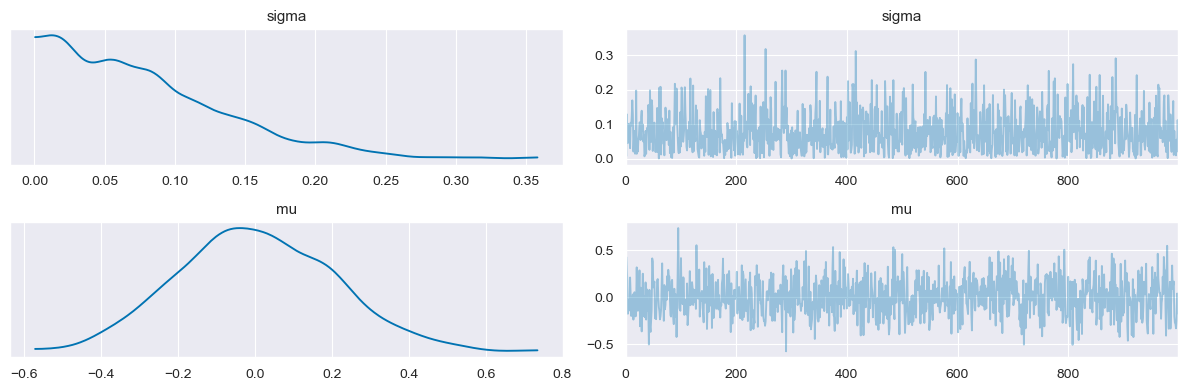

In [37]:
prior = idata_prior.prior
_ = az.plot_trace(prior)
plt.tight_layout()

Dato che le distribuzioni a priori sono adeguate, procediamo con l'inferenza.

In [38]:
with pm.Model() as model:
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    mu = pm.Normal("mu", 0, 0.2)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=df_wide["rt_diff"])
    idata = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


Esaminiamo le distribuzioni a posteriori dei parametri $\mu$ e $\sigma$.

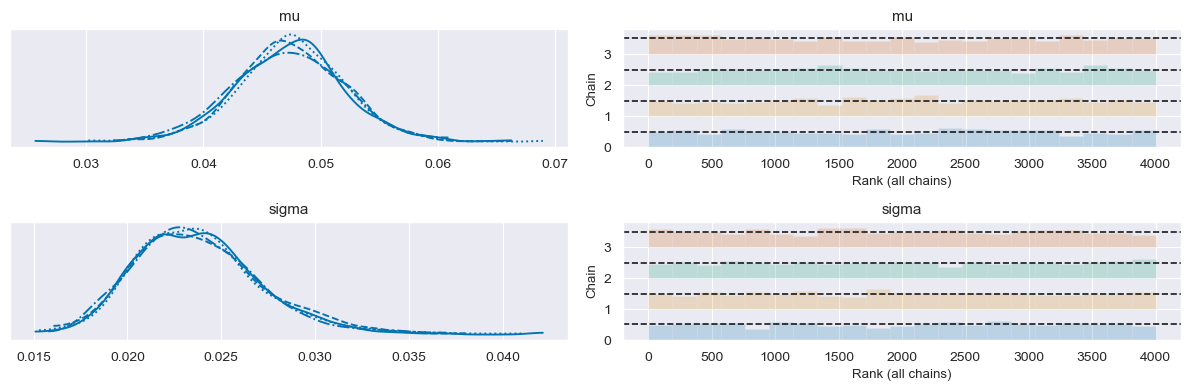

In [39]:
axes = az.plot_trace(idata, divergences="bottom", kind="rank_bars")
plt.tight_layout()

Esaminiamo le tracce.

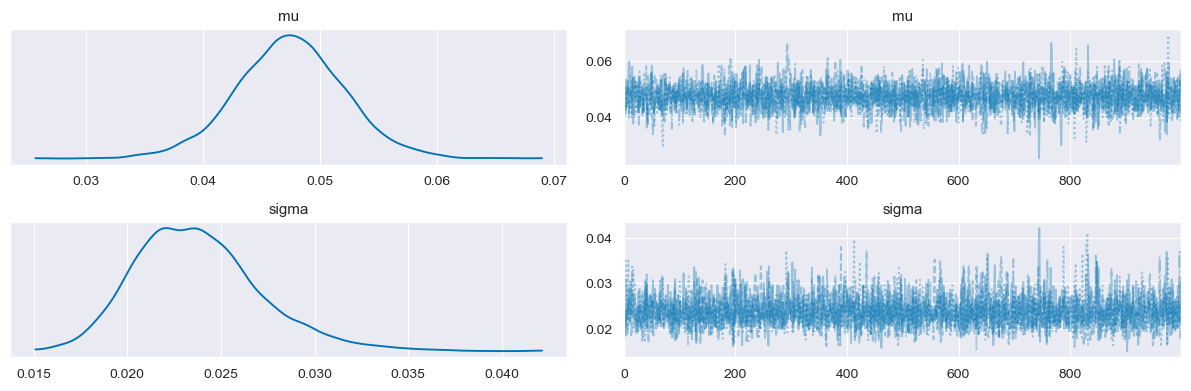

In [40]:
az.plot_trace(idata, combined=True)
plt.tight_layout()


Le quattro catene producono risultati simili.

Text(0.5, 1.0, 'μ Mass Estimate: 94.0% HDI')

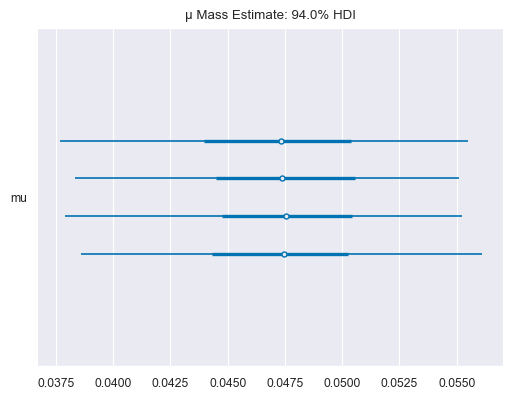

In [42]:
axes = az.plot_forest(
    idata,
    var_names=["mu"],
)
axes[0].set_title("μ Mass Estimate: 94.0% HDI")


Esaminiamo il posterior predictive check.

In [43]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)


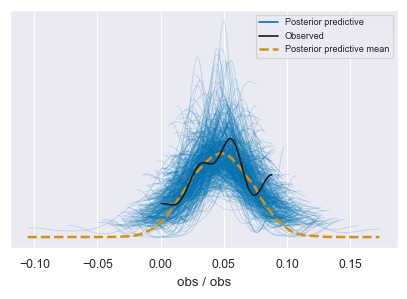

In [44]:
_ = az.plot_ppc(idata, num_pp_samples=500)

La distribuzione predittiva a posteriori è coerente con i dati campionari.

Troviamo l'intervallo di credibilità al 94%.

In [45]:
az.summary(idata, hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.047,0.005,0.038,0.056,0.0,0.0,3757.0,2671.0,1.0
sigma,0.024,0.003,0.017,0.030,0.0,0.0,3387.0,2651.0,1.0


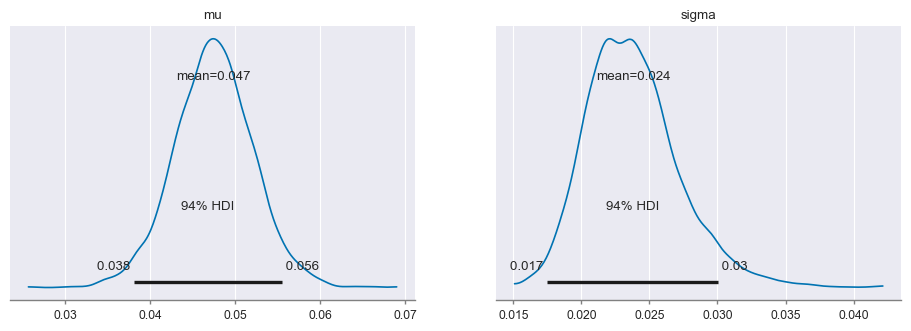

In [46]:
axes = az.plot_posterior(idata, hdi_prob=0.94)

La stima a posteriori dell'effetto flanker è pari a 47 ms. L'intervallo di credibilità [0.038, 0.056] non include lo zero, per cui possiamo concludere, ad un livello di certezza soggettiva del 94%, che la presenza dei flanker produce un'interferenza che riduce la velcità con cui viene eseguito il compito sperimentale rispetto al target.

L'intervallo a posteriori a densità più alta conferma i risultati precedenti.

In [47]:
az.hdi(idata, hdi_prob=0.94)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 0.03802 0.05552
    sigma    (hdi) float64 0.0175 0.03004

## Watermark

In [48]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon May 01 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.1

pytensor: 2.11.1

matplotlib: 3.7.1
seaborn   : 0.12.2
scipy     : 1.10.1
arviz     : 0.15.1
pandas    : 2.0.1
pymc      : 5.3.0
bambi     : 0.10.0
numpy     : 1.24.3

Watermark: 2.3.1

